In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import PIL
%matplotlib inline
import os
import seaborn as sns
import tensorflow as tf
from tqdm.auto import tqdm
import IPython.display as display
import time

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/My Drive/DLProjects/JapaNet

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/DLProjects/JapaNet


In [3]:
df_train = pd.read_csv('train.csv')
df_train.head()

,image_id,labels
0,100241706_00004_2,U+306F 1231 3465 133 53 U+304C 275 1652 84 69 ...
1,100241706_00005_1,U+306F 1087 2018 103 65 U+304B 1456 1832 40 73...
2,100241706_00005_2,U+306F 572 1376 125 57 U+306E 1551 2080 69 68 ...
3,100241706_00006_1,U+3082 1455 3009 65 44 U+516B 1654 1528 141 75...
4,100241706_00007_2,U+309D 1201 2949 27 33 U+309D 1196 1539 27 36 ...


# Adding CenterNet column

In [4]:
centers = []
for i in range(len(df_train)):
    pageData = np.array(df_train.loc[i, "labels"].split(" ")).reshape(-1,5)
    # We drop character label, we won't need it for detection
    pageData = pageData[:, 1:].astype('uint32')
    pageData[:, 0] += pageData[:, 2] // 2   # Center on X 
    pageData[:, 1] += pageData[:, 3] // 2   # Center on Y
    df_train.loc[i, "labels"] = pageData[:, :2].ravel()

In [5]:
df_train.head()

,image_id,labels
0,100241706_00004_2,"[1297, 3491, 317, 1686, 1566, 1252, 246, 3376,..."
1,100241706_00005_1,"[1138, 2050, 1476, 1868, 2068, 1760, 1777, 160..."
2,100241706_00005_2,"[634, 1404, 1585, 2114, 972, 1765, 351, 1867, ..."
3,100241706_00006_1,"[1487, 3031, 1724, 1565, 1754, 1146, 433, 2090..."
4,100241706_00007_2,"[1214, 2965, 1209, 1557, 742, 2227, 970, 3215,..."


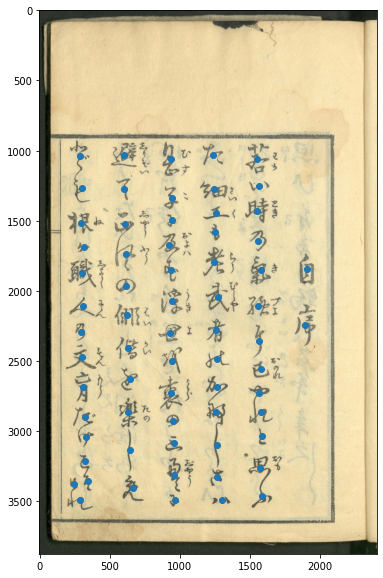

In [6]:
sample = df_train.iloc[0]
plt.figure(figsize  = (10, 10))
plt.imshow(plt.imread("train/" + sample['image_id'] + ".jpg"))
centers = sample['labels'].reshape(-1, 2)
plt.scatter(centers[:, 0], centers[:, 1])

In [7]:
plt.imread("train/" + sample['image_id'] + ".jpg")

array([[[43, 48, 41],
        [44, 49, 42],
        [46, 51, 44],
        ...,
        [36, 41, 35],
        [32, 37, 31],
        [29, 34, 28]],

       [[43, 48, 41],
        [44, 49, 42],
        [45, 50, 43],
        ...,
        [36, 41, 35],
        [33, 38, 32],
        [31, 36, 30]],

       [[42, 47, 40],
        [43, 48, 41],
        [45, 50, 43],
        ...,
        [36, 41, 35],
        [35, 40, 34],
        [35, 40, 34]],

       ...,

       [[46, 51, 44],
        [48, 51, 44],
        [49, 50, 44],
        ...,
        [31, 44, 27],
        [32, 45, 28],
        [33, 46, 29]],

       [[47, 44, 39],
        [42, 39, 34],
        [41, 40, 35],
        ...,
        [38, 46, 35],
        [37, 45, 34],
        [32, 40, 29]],

       [[47, 44, 39],
        [42, 39, 34],
        [41, 40, 35],
        ...,
        [38, 46, 35],
        [37, 45, 34],
        [32, 40, 29]]], dtype=uint8)

# Creating TFRecord from data

In [8]:
class DatasetRecorder:
    def __init__(self, fileName):
        self.fileName = fileName
        self.writer = tf.io.TFRecordWriter(self.fileName)
    
    def _bytes_feature(self, value):
        return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

    def _float_feature(self, value):
        return tf.train.Feature(float_list=tf.train.FloatList(value=value))

    def write(self, image, label):
        feature = {
            'image':  self._bytes_feature(image), # OK
            # 'image':  self._bytes_feature(image.ravel().tobytes()),
            # 'image':  self._bytes_feature(image.encode()),  # OK
            # 'img_shape': self._bytes_feature(np.array(image.shape, dtype=np.uint8).ravel().tobytes()),
            'labels': self._float_feature(label.astype(np.float32))
        }
        sample = tf.train.Example(features=tf.train.Features(feature=feature))
        self.writer.write(sample.SerializeToString())

    def close(self):
        self.writer.flush()
        self.writer.close()
trainRecordPath = 'train/train.tfrecord'

In [9]:
recorder = DatasetRecorder(trainRecordPath)

for i in tqdm(range(len(df_train))):
    sample = df_train.iloc[i]
    recorder.write(open("train/" + sample['image_id'] + ".jpg", 'rb').read(), sample['labels']) # Works
    # recorder.write(plt.imread("train/" + sample['image_id'] + ".jpg"), sample['labels'])  # Huuuuge file
    # recorder.write("train/" + sample['image_id'] + ".jpg", sample['labels']) # Works 
recorder.close()

In [10]:
!du -sh {trainRecordPath}

2.9G	train/train.tfrecord


# Building the input pipeline

In [11]:
record = tf.data.TFRecordDataset(trainRecordPath)

class DataRead:
    def __init__(self):
        self.feature_description = {         
            'image': tf.io.FixedLenFeature([], tf.string),
            'labels': tf.io.VarLenFeature(dtype=tf.float32)            
        }

    def prepdata(self, fmap):
        pmap = tf.io.parse_single_example(fmap, self.feature_description)
        
        # imageRaw = tf.io.read_file(pmap['image']) # WORKS
        # imageDecoded =  tf.image.decode_jpeg(imageRaw, channels=3) / 255
        
        imageDecoded =  tf.image.decode_jpeg(pmap['image'], channels=3) / 255 # WORKS
        imageResized = tf.image.resize(imageDecoded, [512, 512])        
        
        # label = tf.sparse.to_dense(pmap['labels'])                                    
        # return imageResized, label
        return imageResized

In [12]:
reader = DataRead()
trainData = record.map(reader.prepdata, num_parallel_calls=tf.data.experimental.AUTOTUNE)
trainData = trainData
# trainData = trainData.shuffle(1, seed=11, reshuffle_each_iteration=True)
# trainData = trainData.batch(batchSize, drop_remainder=True)
# trainData = trainData.prefetch(tf.data.experimental.AUTOTUNE)

In [13]:
batchSize = 32
numEpochs = 2

trainData = trainData.shuffle(buffer_size=100)
trainData = trainData.batch(batchSize, drop_remainder=True)
trainData = trainData.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# ckpt = tf.train.Checkpoint(step=tf.Variable(0), iterator=trainData)
# manager = tf.train.CheckpointManager(ckpt, 'train_ckpt', max_to_keep=3)

for epoch in range(numEpochs):
    t0 = time.time()
    for batch in trainData:
        print(f"shape: {batch.shape} ({time.time() - t0} seconds reading)")
        t0 = time.time()
    # savePath = manager.save()
    print("End of epoch: ", epoch)

shape: (32, 512, 512, 3) (8.494509220123291 seconds reading)
shape: (32, 512, 512, 3) (1.8823444843292236 seconds reading)
shape: (32, 512, 512, 3) (2.341386318206787 seconds reading)
shape: (32, 512, 512, 3) (2.3025944232940674 seconds reading)
shape: (32, 512, 512, 3) (2.6057822704315186 seconds reading)
shape: (32, 512, 512, 3) (2.6149685382843018 seconds reading)
shape: (32, 512, 512, 3) (2.059309720993042 seconds reading)
shape: (32, 512, 512, 3) (2.324098825454712 seconds reading)
shape: (32, 512, 512, 3) (2.1955978870391846 seconds reading)
shape: (32, 512, 512, 3) (2.1965172290802 seconds reading)
shape: (32, 512, 512, 3) (2.4679136276245117 seconds reading)
shape: (32, 512, 512, 3) (2.1476736068725586 seconds reading)
shape: (32, 512, 512, 3) (2.793722152709961 seconds reading)
shape: (32, 512, 512, 3) (3.033813953399658 seconds reading)
shape: (32, 512, 512, 3) (3.200963020324707 seconds reading)
shape: (32, 512, 512, 3) (3.00242280960083 seconds reading)
shape: (32, 512, 512

In [14]:
# batchSize = 32
# trainData = trainData.shuffle(buffer_size=100).batch(batchSize, drop_remainder=True).prefetch(100)
# numEpochs = 2

# for epoch in range(numEpochs):
#     t0 = time.time()
#     for batch in trainData:
#         print(f"shape: {batch.shape} ({time.time() - t0} seconds reading)")
#         t0 = time.time()
#     print("End of epoch: ", epoch)

In [15]:
# for sample in trainData:
#     image_raw = sample['image'].numpy()
#     display.display(display.Image(data=image_raw))
#     break

In [16]:
# # data, label = trainData.as_numpy_iterator().next()
# data = trainData.as_numpy_iterator().next()
# print(data.shape)
# data[0].shape
# plt.imshow(data[0])